In [7]:
import sys
sys.path.append('../')
sys.path.append('/Users/sdbykov/work/my_packages/nway')

In [8]:
from scripts.utils import data_path, set_mpl
from scripts.cross_match_scripts import fits_to_pandas, pandas_to_fits, assess_goodnes_nway_cross_match
import pandas as pd
import numpy as np
import seaborn as sns
import nway_python_api as nway
%matplotlib inline

# Nway run in distnce-only mode

In [9]:
ero_table = nway.table_from_fits(data_path+'ERO_lhpv_03_23_sd01_a15_g14.fits')
ero_random_table = nway.table_from_fits(data_path+'ERO_lhpv_03_23_sd01_a15_g14_shifted.fits')
desi_table = nway.table_from_fits(data_path+'desi_lh.fits', poserr_value=0.1)
ero_pandas = fits_to_pandas('ERO_lhpv_03_23_sd01_a15_g14.fits')
desi_pandas = fits_to_pandas('desi_lh.fits')

ero_ctps_pandas = pd.read_pickle(data_path+'validation_ctps_ero_desi_lh.pkl')
ero_pandas = ero_pandas.merge(ero_ctps_pandas, on='ID', how='left')

nway_args = {'match_radius':30, 'prior_completeness':1,}

ero_pandas


,EROSITA,ID,RA,DEC,pos_err,ML_FLUX_0,desi_id_true_ctp
0,0,b'SRGe J103744.3+571156',159.434594,57.198788,0.802682,3.284168e-12,NaN
1,1,b'SRGe J110137.5+572926',165.406353,57.490464,0.843224,1.969860e-12,NaN
2,2,b'SRGe J105825.0+564723',164.604366,56.789762,4.574190,1.817511e-12,NaN
3,3,b'SRGe J110537.6+585120',166.406669,58.855424,0.816664,1.505411e-12,NaN
4,4,b'SRGe J102349.9+563347',155.958041,56.563186,0.797151,1.001123e-12,NaN
...,...,...,...,...,...,...,...
9495,9495,b'SRGe J102315.1+561957',155.813071,56.332561,4.828206,1.637604e-15,NaN
9496,9496,b'SRGe J102332.5+562524',155.885436,56.423270,3.936292,1.608667e-15,NaN
9497,9497,b'SRGe J102235.0+561919',155.645874,56.321872,3.697835,1.595806e-15,NaN
9498,9498,b'SRGe J102223.5+562357',155.597875,56.399058,4.029289,1.532857e-15,NaN


In [10]:

nway_res_ero = nway.nwaylib.nway_match(
[ero_table, desi_table],
**nway_args
)

nway_res_ero_random = nway.nwaylib.nway_match(
[ero_random_table, desi_table],
**nway_args
)

    adding angular separation columns
matching: 152204 matches after filtering by search radius
Primary catalogue "EROSITA" (9500), density gives 2.13e+07 objects on entire sky
Catalogue "DESI" (2418574), density gives 2.39e+09 objects on entire sky
Computing distance-based probabilities ...
    correcting for unrelated associations ...
100%|██████████| 9500/9500 [00:03<00:00, 2875.58it/s]

Computing final probabilities ...
    grouping by primary catalogue ID and flagging ...
    adding angular separation columns
matching: 112369 matches after filtering by search radius
Primary catalogue "EROSITA" (8175), density gives 1.83e+07 objects on entire sky
Catalogue "DESI" (2418574), density gives 2.39e+09 objects on entire sky
Computing distance-based probabilities ...
    correcting for unrelated associations ...
100%|██████████| 8175/8175 [00:02<00:00, 3403.81it/s]

Computing final probabilities ...
    grouping by primary catalogue ID and flagging ...



For a false detection rate of <5%
--> use only counterparts with p_any>0.81 (33.22% of matches)
The efficiency is 75.68%
The purity is  75.31%


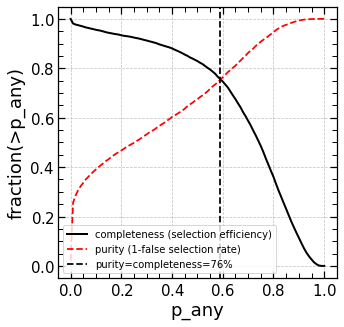

In [11]:
nway.calibrate_cutoff(nway_res_ero, nway_res_ero_random);

## Asses the performance of the NWAY with validation catalog (CSC)

In [12]:
nway_res_ero  = nway_res_ero.merge(ero_pandas, on='EROSITA')
nway_res_ero  = nway_res_ero.merge(desi_pandas, on='DESI')
nway_res_ero.sort_values(by=['EROSITA', 'prob_this_match' ], inplace=True, ascending=[True, False])
nway_res_ero.to_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14_nway_distance_only.pkl')

NWAY PERFOMANCE ON THE VALIDATION CATALOG
Completeness and purity for nway matching 
completeness = fraction of sources with prob_has_match > p 
purity = fraction of sources with prob_has_match > p and correct nway assignment
 Completeness = 85% 
 Purity = 85% 
 prob_has_match optimal cutoff =  0.63 
 Fraction of sources with prob_has_match > 0.63 = 72%
+++Statistics+++
677 X-ray sources in validation set with counterparts
--Out of those, 100 sources were assigned hostless (prob_has_match < 0.63) 
577 sources have prob_has_match > 0.63
Out of those 577: 
--491 sources have correct nway counterpart
--86 sources have incorrect nway counterpart


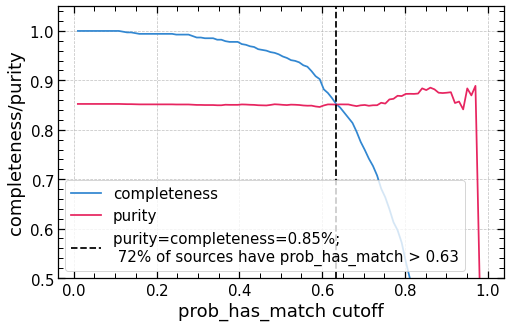

In [13]:
assess_goodnes_nway_cross_match(nway_res_ero);